# 0. Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model #keras 모델의 구조를 시각화
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D #1D와 2D의 차이?
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

warnings.filterwarnings("ignore")

#주피터 노트북에서 Plotly 그래프를 올바르게 표시하기 위해 사용,, 해당 노트북에 쓸 일이 있는지 확인해보자
init_notebook_mode(connected = True)

# 1. 데이터

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/베링랩/엔셀/train.csv', parse_dates = ['date'])
#test = pd.read_csv("test.csv")
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


# 2. EDA
sales를 전체 일별 합, store 별 일별 합, item별 일별 합으로 그래프를 그려보자.

In [ ]:
daily_sales = train.groupby(['date'], as_index = False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index = False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index = False)['sales'].sum()

### 2.1 일별 총 판매량

Text(0, 0.5, 'Sales')

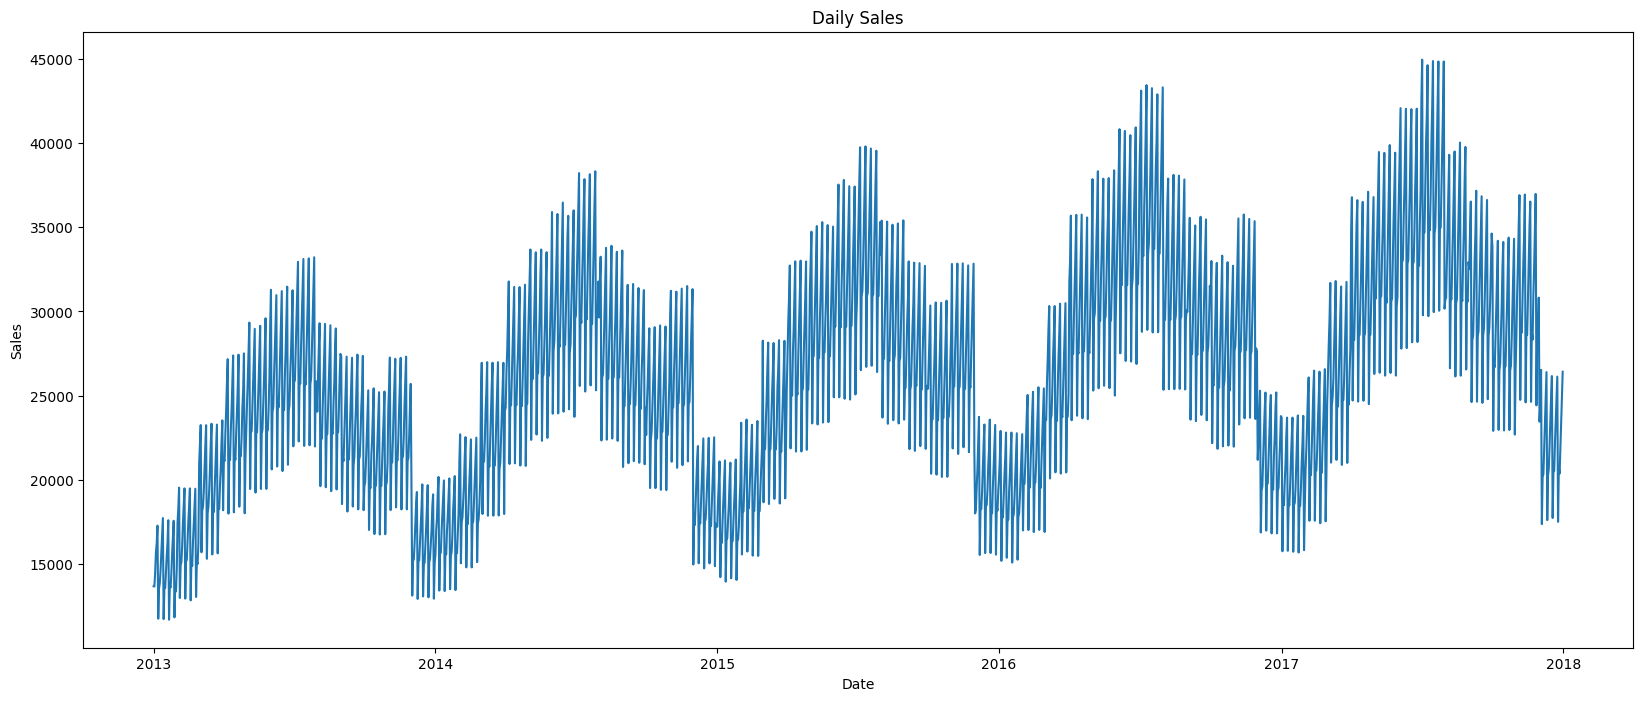

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,8))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

### 2.2 Store별 일별 총 판매량

Text(0, 0.5, 'Sales')

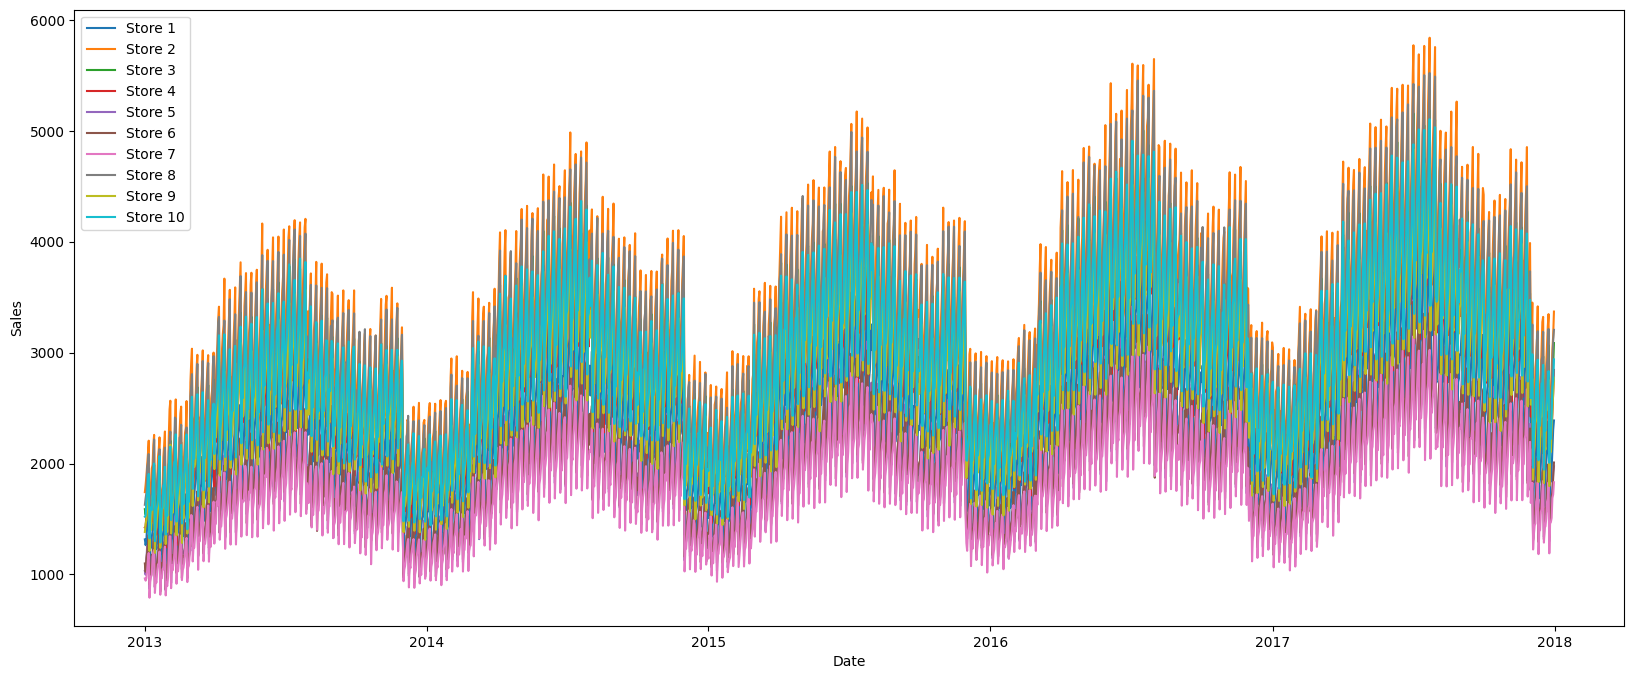

In [ ]:
plt.figure(figsize = (20,8))

for i in range(1,11):
    temp = store_daily_sales[store_daily_sales.store == i]
    plt.plot(temp['date'], temp['sales'], label = f'Store {i}')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

### 2.3 Item별 일별 총 판매량

Text(0, 0.5, 'Sales')

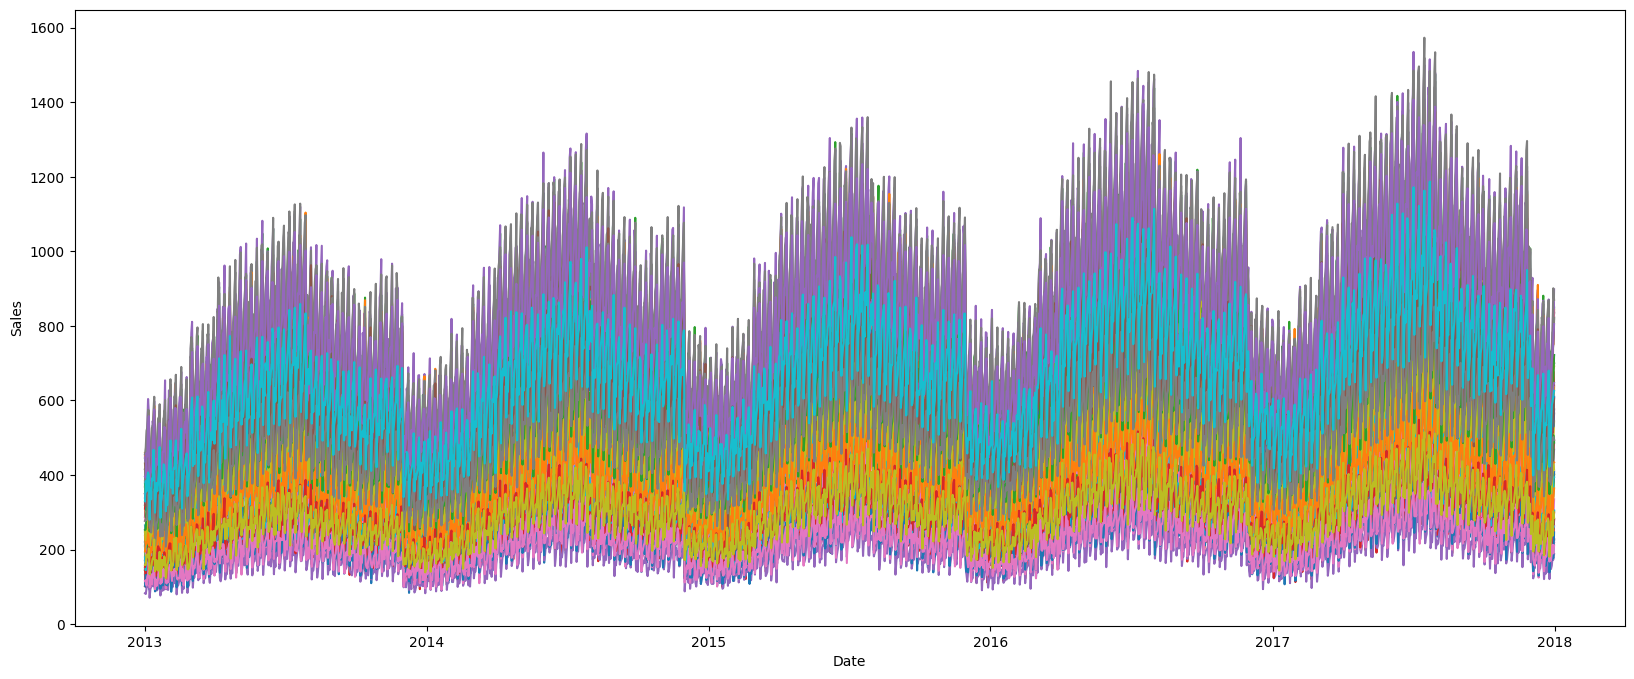

In [ ]:
plt.figure(figsize = (20,8))

for i in range(1,51):
    temp = item_daily_sales[item_daily_sales.item == i]
    plt.plot(temp['date'], temp['sales'], label = f'item {i}')

#plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

전반적으로 미세하게 우상향하는 Trend를 가지며, 1년 단위로 계절성이 뚜렷하게 보인다.

### 4. 전처리
test_set이 2018-01-01부터 2018-03-31까지 이루어져 있다. 즉, 2017-12-31까지의 데이터로 90일 후의 값을 학습해야 하는 것이다.

해당 프로젝트에서는 **30일치로 90일 뒤를 학습**하는 것으로 task를 잡았다.

In [ ]:
#2017년도부터 생각하자
train = train[train.date > '2017-01-01']

In [ ]:
train.sort_values('date')

,date,store,item,sales
1462,2017-01-02,1,1,15
94588,2017-01-02,2,6,38
709950,2017-01-02,9,39,28
708124,2017-01-02,8,39,39
706298,2017-01-02,7,39,12
...,...,...,...,...
617187,2017-12-31,8,34,43
619013,2017-12-31,9,34,21
620839,2017-12-31,10,34,32
597101,2017-12-31,7,33,58


In [ ]:
#date 기준으로 정렬
train_gp = train.sort_values('date').groupby(['item','store','date'], as_index = False)
train_gp = train_gp.agg({'sales' : ['mean']})
train_gp.columns = ['item','store','date','sales']
train_gp

,item,store,date,sales
0,1,1,2017-01-02,15.0
1,1,1,2017-01-03,10.0
2,1,1,2017-01-04,16.0
3,1,1,2017-01-05,14.0
4,1,1,2017-01-06,24.0
...,...,...,...,...
181995,50,10,2017-12-27,63.0
181996,50,10,2017-12-28,59.0
181997,50,10,2017-12-29,74.0
181998,50,10,2017-12-30,62.0


In [ ]:
data = train_gp.drop('date', axis = 1)
data

,item,store,sales
0,1,1,15.0
1,1,1,10.0
2,1,1,16.0
3,1,1,14.0
4,1,1,24.0
...,...,...,...
181995,50,10,63.0
181996,50,10,59.0
181997,50,10,74.0
181998,50,10,62.0


In [ ]:
window = 29
lag = 90
lag_size = lag

cols, names = [],[]

for i in range(window, 0, -1):
    cols.append(data.shift(i)) #29 ~ 1차 차분 데이터
    names += [('%s(t-%d)' %(col, i)) for col in data.columns]
#차분 안한 데이터 삽입(t = 0)
cols.append(data)
names += [('%s(t)' %(col)) for col in data.columns]
#타겟 데이터
cols.append(data.shift(-lag)) #lag가 도대체 무슨 역할이지?
names += [('%s(t+%d)' %(col, lag)) for col in data.columns]

In [ ]:
#전부 합체
agg = pd.concat(cols, axis = 1)
agg.columns = names
agg

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,15.0,1.0,1.0,21.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,15.0,1,1,10.0,1.0,1.0,17.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,1.0,1.0,10.0,1,1,16.0,1.0,1.0,22.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.0,1.0,16.0,1,1,14.0,1.0,1.0,21.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,1.0,1.0,14.0,1,1,24.0,1.0,1.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181995,50.0,10.0,68.0,50.0,10.0,76.0,50.0,10.0,73.0,50.0,...,51.0,50.0,10.0,41.0,50,10,63.0,NaN,NaN,NaN
181996,50.0,10.0,76.0,50.0,10.0,73.0,50.0,10.0,66.0,50.0,...,41.0,50.0,10.0,63.0,50,10,59.0,NaN,NaN,NaN
181997,50.0,10.0,73.0,50.0,10.0,66.0,50.0,10.0,49.0,50.0,...,63.0,50.0,10.0,59.0,50,10,74.0,NaN,NaN,NaN
181998,50.0,10.0,66.0,50.0,10.0,49.0,50.0,10.0,75.0,50.0,...,59.0,50.0,10.0,74.0,50,10,62.0,NaN,NaN,NaN


In [ ]:
#결측치 제거
agg.dropna(inplace = True)
agg

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
30,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
31,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
32,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0
33,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,...,17.0,1.0,1.0,24.0,1,1,25.0,1.0,1.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181905,50.0,10.0,79.0,50.0,10.0,89.0,50.0,10.0,96.0,50.0,...,79.0,50.0,10.0,80.0,50,10,82.0,50.0,10.0,63.0
181906,50.0,10.0,89.0,50.0,10.0,96.0,50.0,10.0,92.0,50.0,...,80.0,50.0,10.0,82.0,50,10,90.0,50.0,10.0,59.0
181907,50.0,10.0,96.0,50.0,10.0,92.0,50.0,10.0,102.0,50.0,...,82.0,50.0,10.0,90.0,50,10,103.0,50.0,10.0,74.0
181908,50.0,10.0,92.0,50.0,10.0,102.0,50.0,10.0,60.0,50.0,...,90.0,50.0,10.0,103.0,50,10,99.0,50.0,10.0,62.0


In [ ]:
series = agg

#window만큼
last_item = 'item(t-%d)' %window
last_store = 'store(t-%d)' %window

#store과 item이 다른 경우 방지
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

#sales를 제외한 columns 제거
columns_to_drop = [('%s(t+%d)' %(col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' %(col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis = 1, inplace = True)
series.drop(['item(t)', 'store(t)'], axis = 1, inplace = True)

하루씩 shift하여 총 29일치를 shift하고, 90일 이후의 값을 붙여준다.  
즉, t 시점을 기준으로 (t-29 ~ t) 시점까지의 값이 X값이고, (t+90) 시점의 값이 Y값이다.

In [ ]:
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
29,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0
30,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,...,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,21.0
31,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,...,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,29.0
32,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24.0,19.0
33,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,29.0,...,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24.0,25.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181905,79.0,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,72.0,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,63.0
181906,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,...,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,59.0
181907,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,...,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,74.0
181908,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,74.0,...,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,99.0,62.0


사실 모델링을 진행하기 전에 추가적인 전처리 과정을 거쳐야 한다. store나 item이 1에서 2로 바뀔 때 shift는 진행하지 않는게 맞다. 이러한 부분은 고려되지 않은 듯 하다.

즉, 현재 데이터는 2017-01-01 ~ 2017-12-31까지의 데이터가 세로 방향으로 10 x 50개가 붙어있는 꼴이다.

### 5. Train/Validation Split

In [ ]:
#Label
labels_col = 'sales(t+%d)'%lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis = 1)

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size = 0.4, shuffle = False, random_state = 0)

In [ ]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (100446, 30)
Validation set shape (66964, 30)


Column 자체가 과거 데이터를 의미한다. 따라서 shuffle을 진행해도 된다.

### 5.1 평가지표 함수 정의
평가지표 : R2, Corr, RMSE, MAPE

In [ ]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1], 3)
    mape = round(
        metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared = False), 3)

    df = pd.DataFrame({
        'R2' : r2,
        'Corr' : corr,
        'RMSE' : rmse,
        'MAPE' : mape
    }, index = [0])

    return df

### 6. MLP
모델에 적용하기에 앞서, 파라미터 몇 가지를 설정해주자.

In [ ]:
#40번 학습 / 한 번에 256 / learning rate : 0.003

epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
#Model Architecture

model_mlp = Sequential()
model_mlp.add(Dense(100, activation = 'relu', input_dim = X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss = 'mse', optimizer = adam)

In [ ]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습하고, prediction한 결과

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data = (X_valid.values, Y_valid),
                            epochs = epochs, verbose = 2)

Epoch 1/40
3139/3139 - 15s - loss: 393.2042 - val_loss: 364.7367 - 15s/epoch - 5ms/step
Epoch 2/40
3139/3139 - 10s - loss: 358.2650 - val_loss: 357.6173 - 10s/epoch - 3ms/step
Epoch 3/40
3139/3139 - 10s - loss: 348.2969 - val_loss: 341.9320 - 10s/epoch - 3ms/step
Epoch 4/40
3139/3139 - 10s - loss: 345.2878 - val_loss: 359.5809 - 10s/epoch - 3ms/step
Epoch 5/40
3139/3139 - 12s - loss: 342.1781 - val_loss: 337.7025 - 12s/epoch - 4ms/step
Epoch 6/40
3139/3139 - 10s - loss: 339.3610 - val_loss: 337.4707 - 10s/epoch - 3ms/step
Epoch 7/40
3139/3139 - 10s - loss: 338.7613 - val_loss: 402.0230 - 10s/epoch - 3ms/step
Epoch 8/40
3139/3139 - 10s - loss: 337.1056 - val_loss: 346.3260 - 10s/epoch - 3ms/step
Epoch 9/40
3139/3139 - 10s - loss: 336.8096 - val_loss: 342.6106 - 10s/epoch - 3ms/step
Epoch 10/40
3139/3139 - 10s - loss: 335.3791 - val_loss: 339.1019 - 10s/epoch - 3ms/step
Epoch 11/40
3139/3139 - 11s - loss: 334.6257 - val_loss: 356.4737 - 11s/epoch - 4ms/step
Epoch 12/40
3139/3139 - 11s - 

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)

Y_train_ = pd.DataFrame({'y_true' : Y_train,
                        'y_pred' : mlp_train_pred.reshape(mlp_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index = True, right_index = True, how = 'left')

Y_valid_ = pd.DataFrame({'y_true' : Y_valid,
                        'y_pred' : mlp_valid_pred.reshape(mlp_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index = True, right_index = True, how = 'left')

2093/2093 [==============================] - 3s 1ms/step


In [ ]:
Y_train_

,y_true,y_pred,item,store,date,sales
30,21.0,16.400444,1,1,2017-02-01,15.0
31,29.0,19.191166,1,1,2017-02-02,17.0
33,28.0,23.238880,1,1,2017-02-04,25.0
34,34.0,31.063068,1,1,2017-02-05,25.0
36,24.0,21.160074,1,1,2017-02-07,12.0
...,...,...,...,...,...,...
181900,75.0,74.466972,50,10,2017-09-23,97.0
181901,70.0,77.346085,50,10,2017-09-24,99.0
181904,41.0,62.793571,50,10,2017-09-27,80.0
181906,59.0,69.016388,50,10,2017-09-29,90.0


In [ ]:
#store : 7, item : 48의 경우를 살펴보자
temp = Y_valid_.loc[(Y_valid_.store == 7) & (Y_valid_.item == 48),].sort_values('date')

scoring(temp.y_true, temp.y_pred)

#R2가 x100을 했는데도 0.5..?

,R2,Corr,RMSE,MAPE
0,-1.139,0.347,12.343,22.22


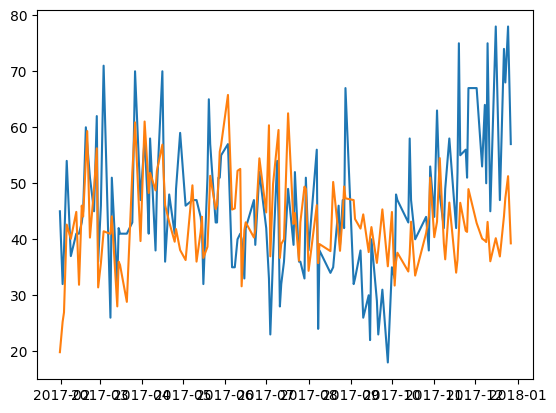

In [ ]:
plt.plot(temp.date, temp.y_true, label = 'Original')
plt.plot(temp.date, temp.y_pred, label = 'Predicte')

### 7. CNN
CNN 아키텍처로 시계열 분석을 하기 위해 Input Data의 Shape을 3차원으로 변형해준다.

In [ ]:
X_train.values

array([[15., 10., 16., ..., 24.,  9., 17.],
       [10., 16., 14., ...,  9., 17., 15.],
       [16., 14., 24., ..., 17., 15., 17.],
       ...,
       [62., 45., 38., ..., 54., 62., 78.],
       [45., 38., 40., ..., 62., 78., 36.],
       [38., 40., 45., ..., 78., 36., 51.]])

In [ ]:
X_train_series.shape

(100446, 30, 1)

In [ ]:
#(100466, 30, 1) = (높이, 너비, 채널 수)
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [ ]:
adam = optimizers.Adam(lr)

model_cnn = Sequential()
#sales는 2차원이 아니라 1차원 데이터이므로 Conv1D
model_cnn.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu',
                    input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size = 2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss = 'mse', optimizer = adam)

In [ ]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 896)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                44850     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data = (X_valid_series, Y_valid), epochs = epochs, verbose = 2)

Epoch 1/40
3139/3139 - 21s - loss: 432.1331 - val_loss: 336.7170 - 21s/epoch - 7ms/step
Epoch 2/40
3139/3139 - 12s - loss: 402.6580 - val_loss: 328.4211 - 12s/epoch - 4ms/step
Epoch 3/40
3139/3139 - 15s - loss: 387.3593 - val_loss: 311.2348 - 15s/epoch - 5ms/step
Epoch 4/40
3139/3139 - 14s - loss: 378.7755 - val_loss: 328.2187 - 14s/epoch - 4ms/step
Epoch 5/40
3139/3139 - 12s - loss: 374.9733 - val_loss: 307.0847 - 12s/epoch - 4ms/step
Epoch 6/40
3139/3139 - 12s - loss: 372.3742 - val_loss: 306.7736 - 12s/epoch - 4ms/step
Epoch 7/40
3139/3139 - 14s - loss: 370.1537 - val_loss: 304.6750 - 14s/epoch - 4ms/step
Epoch 8/40
3139/3139 - 14s - loss: 369.1187 - val_loss: 303.5042 - 14s/epoch - 4ms/step
Epoch 9/40
3139/3139 - 12s - loss: 368.4845 - val_loss: 303.2212 - 12s/epoch - 4ms/step
Epoch 10/40
3139/3139 - 12s - loss: 366.1465 - val_loss: 301.8443 - 12s/epoch - 4ms/step
Epoch 11/40
3139/3139 - 14s - loss: 366.5054 - val_loss: 307.2259 - 14s/epoch - 4ms/step
Epoch 12/40
3139/3139 - 14s - 

In [ ]:
cnn_train_pred = model_cnn.predict(X_train.values)
cnn_valid_pred = model_cnn.predict(X_valid.values)

Y_train_ = pd.DataFrame({'y_true' : Y_train,
                        'y_pred' : cnn_train_pred.reshape(cnn_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index = True, right_index = True, how = 'left')

Y_valid_ = pd.DataFrame({'y_true' : Y_valid,
                        'y_pred' : cnn_valid_pred.reshape(cnn_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index = True, right_index = True, how = 'left')

2093/2093 [==============================] - 4s 2ms/step


In [ ]:
#store : 7, item : 48의 경우를 살펴보자
temp = Y_valid_.loc[(Y_valid_.store == 7) & (Y_valid_.item == 48),].sort_values('date')

scoring(temp.y_true, temp.y_pred)


,R2,Corr,RMSE,MAPE
0,-20.216,0.23,13.313,23.656


	R2	Corr	RMSE	MAPE
0	-25.274	0.292	13.737	23.326

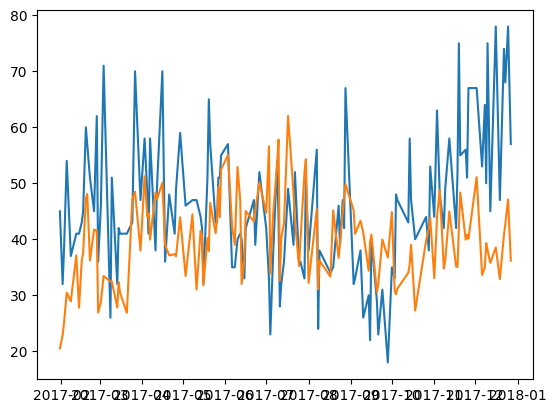

In [ ]:
plt.plot(temp.date, temp.y_true, label = 'Original')
plt.plot(temp.date, temp.y_pred, label = 'Predicte')

### 8. LSTM

In [ ]:
adam = optimizers.Adam(lr)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation = 'relu', input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mse', optimizer = adam)

In [ ]:
#LSTM은 셀 안에 단기 기억 담당과 장기 기억 담당이 있는 등 Dense보다 복잡하기에 param이 10000개가 넘는다
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data = (X_valid_series, Y_valid), epochs = 30, verbose = 2)

Epoch 1/30
3139/3139 - 122s - loss: 687.5998 - val_loss: 365.0063 - 122s/epoch - 39ms/step
Epoch 2/30
3139/3139 - 108s - loss: 431.9450 - val_loss: 329.6484 - 108s/epoch - 34ms/step
Epoch 3/30
3139/3139 - 107s - loss: 396.0325 - val_loss: 316.6821 - 107s/epoch - 34ms/step
Epoch 4/30
3139/3139 - 109s - loss: 430.7902 - val_loss: 340.3335 - 109s/epoch - 35ms/step
Epoch 5/30
3139/3139 - 114s - loss: 476.0530 - val_loss: 362.3449 - 114s/epoch - 36ms/step
Epoch 6/30
3139/3139 - 110s - loss: 563.0867 - val_loss: 831.9755 - 110s/epoch - 35ms/step
Epoch 7/30
3139/3139 - 109s - loss: 774.6476 - val_loss: 438.9938 - 109s/epoch - 35ms/step
Epoch 8/30
3139/3139 - 112s - loss: 600.9636 - val_loss: 428.5381 - 112s/epoch - 36ms/step
Epoch 9/30
3139/3139 - 108s - loss: 507.5331 - val_loss: 500.0004 - 108s/epoch - 35ms/step
Epoch 10/30
3139/3139 - 108s - loss: 480.1479 - val_loss: 343.3803 - 108s/epoch - 34ms/step
Epoch 11/30
3139/3139 - 108s - loss: 462.3474 - val_loss: 370.6418 - 108s/epoch - 34ms/st

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

2093/2093 [==============================] - 13s 6ms/step
Train rmse: 20.036653874882692
Validation rmse: 18.247462647882973
